In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# 1. Load data
csv_files = glob.glob("../raw_data/*.csv")
dfs = {}
for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file, parse_dates=True, index_col=0)

    df = df[~df.index.duplicated(keep='first')]
    num_cols = ["open", "high", "low", "close", "vol", "pct_change", "vwap"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    df['return'] = df['pct_change'] / 100.0

    dfs[symbol] = df


In [3]:
len(list(dfs.keys()))


496

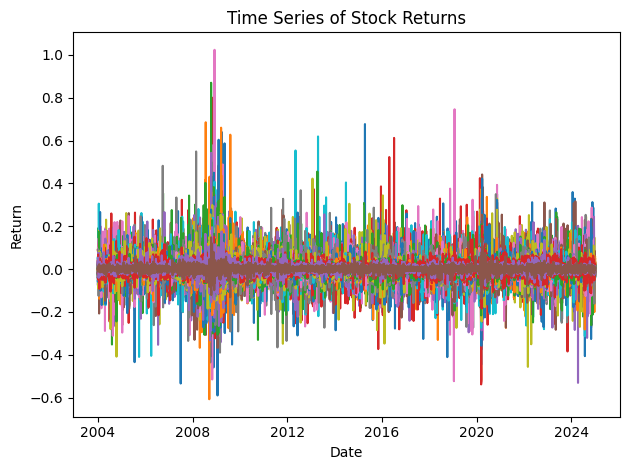

In [4]:
# 3. Comparison of all stocks' returns on time series
returns_df = pd.DataFrame({sym: df['return'] for sym, df in dfs.items()})

plt.figure()
for sym in returns_df.columns:
    plt.plot(returns_df.index, returns_df[sym], label=sym)
plt.title("Time Series of Stock Returns")
plt.xlabel("Date")
plt.ylabel("Return")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

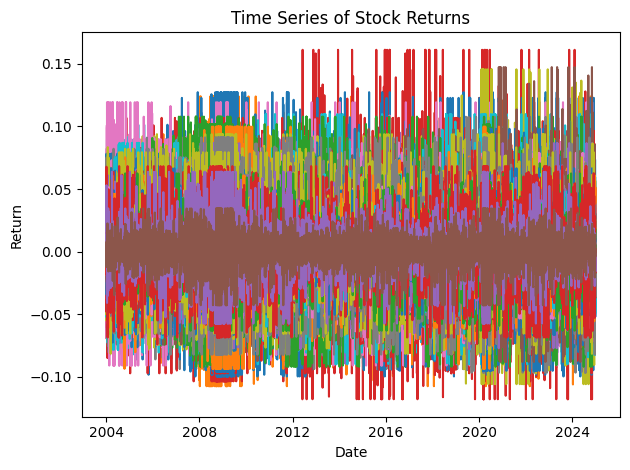

In [5]:
# 4. Outlier handling on combined returns_df
lower = returns_df.quantile(0.01)
upper = returns_df.quantile(0.99)
returns_df = returns_df.clip(lower=lower, upper=upper, axis=1)
plt.figure()
for sym in returns_df.columns:
    plt.plot(returns_df.index, returns_df[sym], label=sym)
plt.title("Time Series of Stock Returns")
plt.xlabel("Date")
plt.ylabel("Return")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [6]:
# # 5. Unit root testing (ADF and KPSS)
# unit_root = []
# for sym, df in dfs.items():
#     series = df['return'].dropna()
#     # ADF
#     adf_res = adfuller(series)
#     # KPSS
#     kpss_res = kpss(series, nlags='auto')
#     unit_root.append({
#         'symbol': sym,
#         'adf_stat': adf_res[0],
#         'adf_pvalue': adf_res[1],
#         'kpss_stat': kpss_res[0],
#         'kpss_pvalue': kpss_res[1]
#     })
# unit_root_df = pd.DataFrame(unit_root).set_index('symbol')
# unit_root_df['stationary'] = np.where((unit_root_df['adf_pvalue'] < 0.05) & (unit_root_df['kpss_pvalue'] > 0.05), True, False)
#
# print("=== Unit Root Test Results ===")
# print(unit_root_df)



In [7]:
# unit_root_df['stationary'] = np.where((unit_root_df['adf_pvalue'] < 0.05) & (unit_root_df['kpss_pvalue'] > 0.05), 1, 0)
#
# print("=== Unit Root Test Results ===")
# print(unit_root_df)

In [8]:
# unit_root_df.describe()

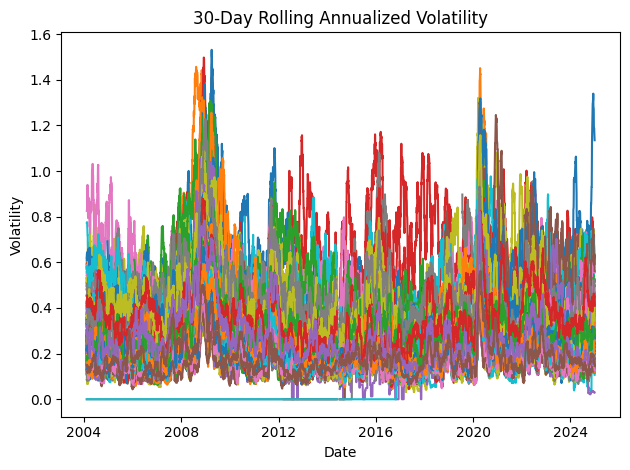

In [9]:
# 5. Volatility analysis: rolling standard deviation
window = 30  # days
vol_df = returns_df.rolling(window).std() * np.sqrt(252)  # annualized volatility

plt.figure()
for sym in vol_df.columns:
    plt.plot(vol_df.index, vol_df[sym], label=sym)
plt.title(f"{window}-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
#plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [10]:
# # 6. Seasonality: seasonal decomposition of closing price for each stock
# seasonal_results = {}
# for sym, df in dfs.items():
#     # use closing price series
#     series = df['close'].asfreq('B')  # business-day frequency
#     series = series.interpolate()
#     if len(series) < 504:
#         print(f"Not enough data for {sym} for seasonal decomposition.")
#         continue
#     decomposition = seasonal_decompose(series, model='additive', period=252)
#     seasonal_results[sym] = decomposition
#     # Plot
#     #fig = decomposition.plot()
#     #fig.suptitle(f"Seasonal Decomposition for {sym}")
#     #plt.tight_layout()
#     #plt.show()



In [11]:
# # 7. Seasonal strength metric
# # Seasonal strength = var(seasonal) / (var(seasonal) + var(resid))
# strength = {}
# for sym, dec in seasonal_results.items():
#     var_seas = np.nanvar(dec.seasonal)
#     var_resid = np.nanvar(dec.resid)
#     strength[sym] = var_seas / (var_seas + var_resid)
# strength_df = pd.Series(strength, name='seasonal_strength')
# print("=== Seasonal Strength by Symbol ===")
# print(strength_df)


In [12]:
# # 8. Average monthly seasonal pattern
# # Align all seasonal series and compute mean by month-of-year
# all_seasonal = pd.DataFrame({sym: dec.seasonal for sym, dec in seasonal_results.items()})
# all_seasonal.index = pd.DatetimeIndex(all_seasonal.index)
# monthly_pattern = all_seasonal.groupby(all_seasonal.index.month).mean()
#
# plt.figure(figsize=(10,6))
# for sym in monthly_pattern.columns:
#     plt.plot(monthly_pattern.index, monthly_pattern[sym], marker='o', label=sym)
# plt.title('Average Monthly Seasonal Pattern')
# plt.xlabel('Month')
# plt.ylabel('Seasonal Component')
# plt.xticks(range(1,13))
# #plt.legend(loc='upper left', bbox_to_anchor=(1,1))
# plt.tight_layout()
# plt.show()

In [13]:
# # 9 box test and arch effect
# from statsmodels.stats.diagnostic import acorr_ljungbox
#
# box_test = []
# for sym, df in dfs.items():
#     series = df['return'].dropna()
#     # ADF
#     result_ = acorr_ljungbox(series, lags=20, return_df=False).iloc[-1]
#
#     result_arch = acorr_ljungbox(series**2, lags=20, return_df=False).iloc[-1]
#
#     box_test.append({
#         'symbol': sym,
#         'box_stat': result_['lb_stat'],
#         'box_pvalue': result_['lb_pvalue'],
#         'ARCH_stats': result_arch['lb_stat'],
#         'ARCH_pvalue': result_arch['lb_pvalue']
#     })
#
# box_test_df = pd.DataFrame(box_test).set_index('symbol')
#
# box_test_df['Exist_Arch_Effect'] = np.where(box_test_df['ARCH_pvalue'] < 0.05, True, False)
# box_test_df['Exist_Autocorr'] = np.where(box_test_df['box_pvalue'] < 0.05, True, False)
# print("=== Box Test Results ===")
# print(box_test_df)
